UPLOAD TENSORS TO COLAB USING CELL BELOW

In [144]:
import pickle
import random
import string
import tensorflow as tf
import re
from google.colab import files
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
!pip install -q --upgrade keras-nlp tensorflow
import keras_nlp
upload = files.upload()

Saving 636Project.keras to 636Project.keras


In [40]:
train_raw = pickle.load(open("DS_5_train_input", 'rb'))
train_input = pickle.load(open("DS_5_train_input_prefixList", 'rb'))
train_output = pickle.load(open("DS_5_train_input_nextWord", 'rb'))
test_input = pickle.load(open("DS_6_test_input_prefixList", 'rb'))
# for i in range(len(train_output)):
#   train_output[i] = "[start] " + train_output[i] + " [end]"

CREATE VALIDATION SET

In [41]:
validation = []
random.Random(6000).shuffle(train_raw)
num_val_samples = int(0.2 * len(train_raw))
val = train_raw[-num_val_samples:]
train = train_raw[:len(train_raw) - num_val_samples]
print(len(train), len(val))
print(train[1000])
print(len(max(train, key = len)))

4000 1000
a j a j a g c e a g b e b d a j a e b f c d c d c e a k c e c d b e 
128


USE TEXTVECTORIZATION LAYER TO OBTAIN VOCABULARY

In [90]:
vocab_size = 500
sequence_length = 150

text_vectorization = layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length,
)
text_vectorization.adapt(train)
print(text_vectorization.get_vocabulary())

['', '[UNK]', 'a', 'b', 'c', 'e', 'g', 'd', 'f', 'k', 'j', 'i', 'h']


CREATE DATASET WITH SEQ2SEQ FORMATTING

In [91]:
def format_dataset(data):
  vectorized = text_vectorization(data)
  data_in = vectorized[:, :-1]
  data_out = vectorized[:, 1:]
  return data_in, data_out

def make_dataset(data, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(data)
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset, num_parallel_calls = 4)
  return dataset.shuffle(6001).prefetch(16).cache()

In [104]:
batch_size = 256
train_ds = make_dataset(train, batch_size)
val_ds = make_dataset(val, batch_size)

In [105]:
for inputs, targets in train_ds.take(1):
  print(f"inputs.shape: {inputs.shape}")
  print(f"targets.shape: {targets.shape}")

inputs.shape: (256, 149)
targets.shape: (256, 149)


CREATE EMBEDDING AND DECODER ARCHITECTURE USING TRANSFORMER CLASS

In [139]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

inputs = keras.layers.Input(shape=(None,), dtype="int64")
x = keras_nlp.layers.TokenAndPositionEmbedding(vocab_size, sequence_length, embed_dim)(inputs)
x = keras_nlp.layers.TransformerDecoder(dense_dim, num_heads)(x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [140]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddin  (None, None, 256)        166400    
 g_7 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_decoder_10 (Tra  (None, None, 256)        1315072   
 nsformerDecoder)                                                
                                                                 
 dense_56 (Dense)            (None, None, 500)         128500    
                                                                 
Total params: 1,609,972
Trainable params: 1,609,972
Non-trainable params: 0
_________________________________________________

In [153]:
callbacks = [
    keras.callbacks.ModelCheckpoint("636Project.keras",
                                    save_best_only=True,
                                    monitor="val_loss"),
                                    
]

opt = keras.optimizers.Adam(learning_rate=0.0005)
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=callbacks)

Epoch 1/25
16/16 [==============================] - 8s 223ms/step - loss: 2.1588 - accuracy: 0.5590 - val_loss: 0.4874 - val_accuracy: 0.7827
Epoch 2/25
16/16 [==============================] - 3s 185ms/step - loss: 0.4380 - accuracy: 0.8008 - val_loss: 0.4173 - val_accuracy: 0.8056
Epoch 3/25
16/16 [==============================] - 3s 185ms/step - loss: 0.4141 - accuracy: 0.8070 - val_loss: 0.4119 - val_accuracy: 0.8054
Epoch 4/25
16/16 [==============================] - 3s 187ms/step - loss: 0.4094 - accuracy: 0.8076 - val_loss: 0.4086 - val_accuracy: 0.8061
Epoch 5/25
16/16 [==============================] - 3s 188ms/step - loss: 0.4069 - accuracy: 0.8079 - val_loss: 0.4066 - val_accuracy: 0.8061
Epoch 6/25
16/16 [==============================] - 3s 187ms/step - loss: 0.4053 - accuracy: 0.8081 - val_loss: 0.4054 - val_accuracy: 0.8062
Epoch 7/25
16/16 [==============================] - 3s 189ms/step - loss: 0.4041 - accuracy: 0.8082 - val_loss: 0.4043 - val_accuracy: 0.8064
Epoch 

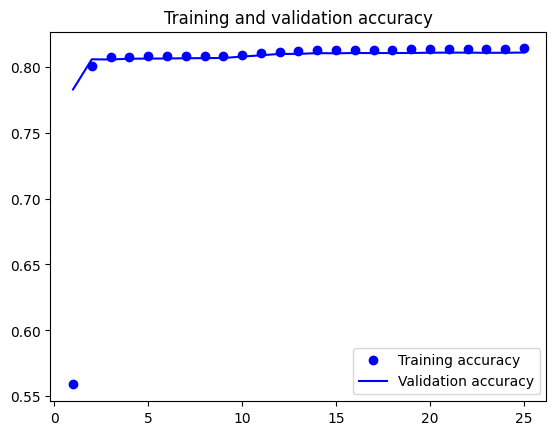

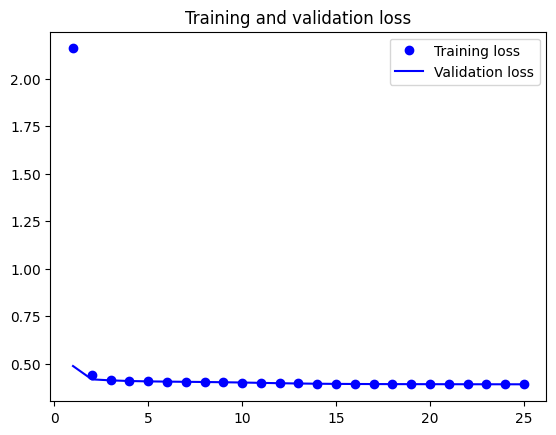

In [154]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

DECODE SENTENCE USING SAMPLED TOKENS AND A NEW TEXTVECTORIZATION THAT DOESN'T SPLIT DATA WITH VOCABULARY INITIALIZED TO THE ORIGINAL

---



In [128]:
no_split = layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    split = None, #don't need to split as partial texts are already split into words
    output_sequence_length = sequence_length,
)
no_split.set_vocabulary(text_vectorization.get_vocabulary())

In [129]:
from numpy.random import multinomial
token_indexes = dict(enumerate(text_vectorization.get_vocabulary()))
max_decoded_sentence_length = 1

def sample_next(predictions, temperature=0.01): 
 predictions = np.asarray(predictions).astype("float64")
 predictions = np.log(predictions) / temperature
 exp_preds = np.exp(predictions)
 predictions = exp_preds / np.sum(exp_preds)
 probas = np.random.multinomial(1, predictions, 1)
 return np.argmax(probas)

def get_next(input_sentence, model):
  for i in range(max_decoded_sentence_length):
    tokenized_input_sentence = no_split([input_sentence])
    predictions = model(tokenized_input_sentence)
    sampled_token_index = sample_next(predictions[0, len(input_sentence) - 1, :])
    sampled_token = token_indexes[sampled_token_index]
    return sampled_token

LOAD MODEL HERE

In [145]:
saved_model = keras.models.load_model(
    "636Project.keras")

In [131]:
output_texts = []
for i in range(len(test_input)):
  input_sentence = test_input[i]
  output_sentence = get_next(input_sentence, saved_model)
  output_texts.append(output_sentence)
  if i % 100 == 0:
    print(str(i) + " of " + str(len(test_input)) + ":-")
    print(input_sentence)
    print(output_sentence)

0 of 5000:-
['a', 'd', 'a', 'h', 'a', 'f', 'a', 'e', 'a', 'k', 'a', 'g', 'a', 'h', 'c', 'f', 'c', 'g', 'a', 'e', 'c', 'f', 'a', 'f', 'a', 'h', 'c', 'e', 'c', 'e', 'b', 'e', 'b', 'd', 'b']
e
100 of 5000:-
['a', 'g', 'a', 'd', 'c', 'e', 'a', 'k', 'c', 'e', 'a', 'g', 'b', 'e', 'a', 'f', 'a', 'i']
a
200 of 5000:-
['a', 'f', 'b', 'e', 'a', 'k', 'a', 'j', 'b', 'g', 'c', 'g', 'b', 'e', 'a', 'g', 'a', 'j', 'a', 'k', 'a', 'k', 'a', 'd', 'a', 'f', 'b', 'e', 'c', 'e', 'b', 'd', 'a', 'f']
c
300 of 5000:-
['a', 'j', 'a', 'j', 'a', 'f', 'b', 'd', 'b', 'd', 'a', 'h', 'b', 'f', 'a', 'j', 'c', 'g', 'c', 'g', 'c', 'g', 'c', 'f', 'c']
f
400 of 5000:-
['a', 'k', 'c', 'f', 'a', 'g', 'a', 'd', 'c', 'f', 'a', 'e', 'a', 'k', 'a', 'h', 'a', 'g', 'c', 'd', 'c', 'e', 'a', 'e']
a
500 of 5000:-
['a', 'd', 'a', 'f', 'a', 'd', 'a', 'k', 'b', 'd', 'b', 'f', 'a', 'i', 'c', 'd', 'b', 'g', 'b', 'e', 'a', 'd', 'c']
f
600 of 5000:-
['a', 'h', 'c', 'e', 'c', 'e', 'a', 'k', 'c', 'd', 'a', 'h', 'b', 'd', 'a', 'h', 'c', 'e', 

UNCOMMENT THE LINE BELOW AND DELETE THE SECOND LINE

In [148]:
# test_output = pickle.load(open("DS_6_test_input_nextWord", 'rb'))     #<- UNCOMMENT THIS LINE
test_output = test_input #<- DELETE THIS LINE 

RUN THE LINE BELOW TO COMPUTE NUMBER OF WORDS CORRECT

In [149]:
count = 0
for i in range(len(output_texts)):
  if output_texts[i] == test_output[i]:
    count += 1

print(count)
print(count / 500)

0
0.0


In [150]:
pickle.dump(output_texts, open("output_texts", 'wb'))

EVALUATE MODEL USING DEFAULT ACCURACY METHOD (RUN THIS LINE)

In [151]:
print(f"Test acc: {saved_model.evaluate(val_ds)[1]:.3f}")

4/4 [==============================] - 0s 87ms/step - loss: 0.3922 - accuracy: 0.8115
Test acc: 0.812


In [152]:
files.download("output_texts")
files.download("636Project.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>